<a href="https://colab.research.google.com/github/albert-yue/gcn-explainability/blob/master/notebooks/experiment_mr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cd gdrive/My\ Drive/MIT/gcn_explainability/

/content/gdrive/My Drive/MIT/gcn_explainability


In [0]:
!git pull

remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/albert-yue/gcn-explanability
   b9a08fa..6006d78  master     -> origin/master
Updating b9a08fa..6006d78
Fast-forward
 notebooks/6864_final_project_r8.ipynb | 5923 +++++++++++++++++++++++++++++++++
 1 file changed, 5923 insertions(+)
 create mode 100644 notebooks/6864_final_project_r8.ipynb


# Train/Test Split

In [0]:
import random

examples = {}
with open('data/mr.txt', 'r') as f:
    for row in f.readlines():
        row = row.strip()
        label, text = row.split('\t')
        if label not in examples:
            examples[label] = [text]
        else:
            examples[label].append(text)
  
with open('data/train-mr.txt', 'w+') as train, open('data/test-mr.txt', 'w+') as test:
    for label, label_examples in examples.items():
        random.shuffle(label_examples)
        ex_len = len(label_examples)
        train_end = int(0.8 * ex_len)
        train_data = label_examples[:train_end]
        test_data = label_examples[train_end:]
        for text in train_data:
            train.write(label)
            train.write('\t')
            train.write(text)
            train.write('\n')
        for text in test_data:
            test.write(label)
            test.write('\t')
            test.write(text)
            test.write('\n')

# Set up Vocabulary and Labels

In [0]:
from src.data import save_all_labels

save_all_labels('data/mr-labels.txt', 'data/train-mr.txt', 'data/test-mr.txt')

In [0]:
from src.data import save_vocabulary

save_vocabulary('data/mr-vocabulary.txt', 'data/train-mr.txt', 'data/test-mr.txt', doc_freq_threshold=0)

# Training

In [0]:
from src.data import Corpus, get_data, get_vocabulary, get_labels
from src.models.gcn import GCN
from src.preprocessing import clean_text, build_adj_matrix, normalize_adj
from src.train import train, evaluate, accuracy

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
from matplotlib import pyplot as plt

def plot_loss(train_losses, val_losses):
    plt.title("MovieReviews Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.legend(loc='lower left')

In [0]:
seed = 0
val_split = 0.1

vocab = get_vocabulary('data/mr-vocabulary.txt')
labels = get_labels('data/mr-labels.txt')
corpus = get_data('data/train-mr.txt', labels)
test_corpus = get_data('data/test-mr.txt', labels)

# Split validation set
corpus.shuffle(seed)
len_train = int(len(corpus) * (1 - val_split))
train_corpus = Corpus(corpus[:len_train])
val_corpus = Corpus(corpus[len_train:])

num_documents = len(train_corpus) + len(val_corpus) + len(test_corpus)

In [0]:
# Mask out unknown words
clean_text(corpus, vocab)
clean_text(test_corpus, vocab)

## Separate Matrices

In [0]:
train_adj_matrix = build_adj_matrix(train_corpus, vocab, num_documents, doc_offset=0)
val_adj_matrix = build_adj_matrix(val_corpus, vocab, num_documents, doc_offset=len(train_corpus))
test_adj_matrix = build_adj_matrix(test_corpus, vocab, num_documents, doc_offset=len(train_corpus) + len(val_corpus))

In [0]:
from src.utils import save_sparse_tensor

save_sparse_tensor(train_adj_matrix, 'data/mr_train_adj_matrix.pt')
save_sparse_tensor(val_adj_matrix, 'data/mr_val_adj_matrix.pt')
save_sparse_tensor(test_adj_matrix, 'data/mr_test_adj_matrix.pt')

In [0]:
from src.utils import load_sparse_tensor

train_adj_matrix = load_sparse_tensor('data/mr_train_adj_matrix.pt')
val_adj_matrix = load_sparse_tensor('data/mr_val_adj_matrix.pt')
test_adj_matrix = load_sparse_tensor('data/mr_test_adj_matrix.pt')

In [0]:
train_adj_matrix = normalize_adj(train_adj_matrix)
val_adj_matrix = normalize_adj(val_adj_matrix)
test_adj_matrix = normalize_adj(test_adj_matrix)

In [0]:
hidden_size = 200  # hyperparameter
dropout = 0.5  # hyperparameter
epochs = 700

num_vertices = len(vocab) + num_documents
model = GCN(num_vertices, hidden_size, len(labels), dropout=dropout)

In [0]:
%time train_losses, val_losses = train(model, train_adj_matrix, val_adj_matrix, train_corpus.labels(), val_corpus.labels(), len(vocab), epochs=epochs, plot_every=5, print_every=10, save_path='gcn_mr_train.pt')

In [0]:
plot_loss(train_losses, val_losses)

In [0]:
test_start_idx = len(vocab) + len(train_corpus) + len(val_corpus)
test_loss = evaluate(model, test_adj_matrix, test_corpus.labels(), accuracy, start_idx=test_start_idx)
print(test_loss)

## Full Matrix

In [0]:
full_corpus = Corpus(train_corpus.data + val_corpus.data + test_corpus.data)

In [0]:
%time adj_matrix = build_adj_matrix(full_corpus, vocab, num_documents, doc_offset=0)

Building word frequencies per doc



Building word frequencies per window



Calculating PMIs



Calculating TF-IDF



Identities



CPU times: user 42.8 s, sys: 595 ms, total: 43.4 s
Wall time: 43.6 s


In [0]:
from src.utils import save_sparse_tensor

save_sparse_tensor(adj_matrix, 'data/mr_full_adj_matrix.pt')

In [0]:
from src.utils import load_sparse_tensor

adj_matrix = load_sparse_tensor('data/mr_full_adj_matrix.pt')

In [0]:
adj_matrix = normalize_adj(adj_matrix)

In [0]:
hidden_size = 200  # hyperparameter
dropout = 0.5  # hyperparameter
epochs = 700
lr = 0.02

num_vertices = len(vocab) + num_documents
model = GCN(num_vertices, hidden_size, len(labels), dropout=dropout)

In [0]:
%time train_losses, val_losses = train(model, adj_matrix, adj_matrix, train_corpus.labels(), val_corpus.labels(), len(vocab), epochs=epochs, init_lr=lr, plot_every=5, print_every=10, save_path='gcn_mr_full.pt')

Epoch 0
Train mean cross-entropy: 0.6937528252601624
Validation mean cross-entropy: 0.6630256772041321
Epoch 10
Train mean cross-entropy: 0.23140756785869598
Validation mean cross-entropy: 0.559371829032898
CPU times: user 16.5 s, sys: 387 ms, total: 16.9 s
Wall time: 17.5 s


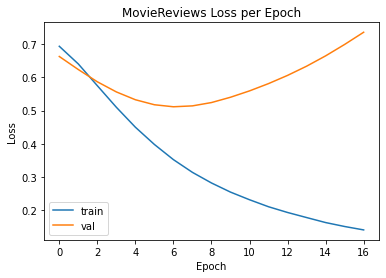

In [0]:
plot_loss(train_losses, val_losses)

In [0]:
test_start_idx = len(vocab) + len(train_corpus) + len(val_corpus)
test_loss = evaluate(model, adj_matrix, test_corpus.labels(), accuracy, start_idx=test_start_idx)
print(test_loss)

0.7474226804123711


In [0]:
print(train_losses)
print(val_losses)

[0.6937528252601624, 0.6405383348464966, 0.5749884247779846, 0.509996235370636, 0.44992145895957947, 0.39794954657554626, 0.3522256910800934, 0.31386345624923706, 0.28192171454429626, 0.2544214725494385, 0.23140756785869598, 0.2102920264005661, 0.1930277943611145, 0.17774972319602966, 0.162656769156456, 0.15077745914459229, 0.1404901146888733]
[0.6630256772041321, 0.6236962080001831, 0.5867929458618164, 0.5562684535980225, 0.5327162146568298, 0.5176151990890503, 0.5115280747413635, 0.5142209529876709, 0.5242307186126709, 0.5402238368988037, 0.559371829032898, 0.5813698768615723, 0.6060736775398254, 0.6337647438049316, 0.6649123430252075, 0.6993379592895508, 0.7360756397247314]
